# ADM - HW5 - The Marvel Universe!

## Libraries & Setup

In [1]:
import networkx as nx   # Network analysis

import pandas as pd   # Data manipulation and analysis
import numpy as np    # Scientific Computing

import matplotlib as mpl   # Visualization
import matplotlib.pyplot as plt   # Visualization
import seaborn as sns   # Visualization

from tabulate import tabulate   # table visualization

import warnings
warnings.filterwarnings('ignore')

# 1. Data

## Data Preprocessing

In [2]:
nodes_df = pd.read_csv("nodes.csv")
edges_df = pd.read_csv("edges.csv")
hero_network_df = pd.read_csv("hero-network.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'nodes.csv'

In [4]:
nodes_df

node   type
0                   2001 10  comic
1                    2001 8  comic
2                    2001 9  comic
3      24-HOUR MAN/EMMANUEL   hero
4      3-D MAN/CHARLES CHAN   hero
...                     ...    ...
19085           ZOTA, CARLO   hero
19086                  ZOTA   hero
19087                 ZURAS   hero
19088                  ZURI   hero
19089                 ZZZAX   hero

[19090 rows x 2 columns]

In [5]:
edges_df

hero     comic
0      24-HOUR MAN/EMMANUEL    AA2 35
1      3-D MAN/CHARLES CHAN     AVF 4
2      3-D MAN/CHARLES CHAN     AVF 5
3      3-D MAN/CHARLES CHAN     COC 1
4      3-D MAN/CHARLES CHAN    H2 251
...                     ...       ...
96099                 ZZZAX    H2 326
96100                 ZZZAX    H2 327
96101                 ZZZAX  M/CP 8/4
96102                 ZZZAX     PM 47
96103                 ZZZAX   WCA2 12

[96104 rows x 2 columns]

In [6]:
hero_network_df

hero1                 hero2
0              LITTLE, ABNER        PRINCESS ZANDA
1              LITTLE, ABNER  BLACK PANTHER/T'CHAL
2       BLACK PANTHER/T'CHAL        PRINCESS ZANDA
3              LITTLE, ABNER        PRINCESS ZANDA
4              LITTLE, ABNER  BLACK PANTHER/T'CHAL
...                      ...                   ...
574462  COLOSSUS II/PETER RA              CALLISTO
574463              CALLISTO               ROGUE /
574464              CALLISTO              CALIBAN/
574465              CALIBAN/               ROGUE /
574466  HULK/DR. ROBERT BRUC     MARKS, DR. SHIELA

[574467 rows x 2 columns]

For the data to be *consistent* across all the dataframes, **all hero names** appearing in the *hero_network* dataframe should **also be found** in the *edges* dataframe

In [ ]:
# Retrieve heroes' names appearing in "hero_network" dataframe, but not in "edges" dataframe
def check_inconsistency():
    names = set(hero_network_df.hero1).union(set(hero_network_df.hero2)).difference(set(edges_df.hero))
    out = names if len(names)!=0 else "No inconsistencies found!"
    return out

In [8]:
# Some inconsistency examples
list(check_inconsistency())[:10]

['KLIGGER/SEN. EUGENE ',
 'WORTHINGTON, WARREN ',
 'LIVING LASER/ARTHUR ',
 'CHI DEMON/PROFESSOR ',
 'SILVERCLAW/LA GARRA ',
 'BRADDOCK, JAMES JR. ',
 'CEREBRO MARK XIII | ',
 'MR. SINISTER/NATHAN ',
 'SPAR, DR. KATHERINE ',
 'KILLER SHRIKE/SIMON ']

**Inconsistency reason 1:** some heroes' names in the *hero_network* dataframe have **extra spaces** at the end of their names

In [3]:
hero_network_df.hero1 = [x.strip() for x in hero_network_df.hero1]
hero_network_df.hero2 = [x.strip() for x in hero_network_df.hero2]

NameError: name 'hero_network_df' is not defined

In [10]:
check_inconsistency()

{'BLADE', 'SABRE', 'SPIDER-MAN/PETER PAR'}

**Inconsistency reason 2:** some heroes in the *hero_network* dataframe **are missing a "/"** at the end of their names. In fact, *BLADE* and *SABRE* are labelled as **comics** in the *nodes* dataframe, while *BLADE/* and *SABRE/* represent the actual **heroes**

In [6]:
hero_network_df.loc[hero_network_df["hero1"] == "BLADE", "hero1"] = "BLADE/"
hero_network_df.loc[hero_network_df["hero2"] == "BLADE", "hero2"] = "BLADE/"
hero_network_df.loc[hero_network_df["hero1"] == "SABRE", "hero1"] = "SABRE/"
hero_network_df.loc[hero_network_df["hero2"] == "SABRE", "hero2"] = "SABRE/"

In [12]:
check_inconsistency()

{'SPIDER-MAN/PETER PAR'}

**Inconsistency reason 3:** the hero name *"SPIDER-MAN/PETER PARKER"* in the *edges* dataframe has been changed to *"SPIDER-MAN/PETER PAR"* the *hero_network* dataframe

In [7]:
hero_network_df.loc[hero_network_df["hero1"] == "SPIDER-MAN/PETER PAR", "hero1"] = "SPIDER-MAN/PETER PARKER"
hero_network_df.loc[hero_network_df["hero2"] == "SPIDER-MAN/PETER PAR", "hero2"] = "SPIDER-MAN/PETER PARKER"

In [14]:
check_inconsistency()

'No inconsistencies found!'

We also remove entries of the *hero_network* dataframe having the same hero in **both columns** (in order to avoid **self-loops** in the graph)

In [15]:
# With self-loop records
len(hero_network_df)

574467

In [8]:
hero_network_df.drop(hero_network_df[hero_network_df['hero1'] == hero_network_df['hero2']].index, inplace = True)

In [17]:
# Without self-loop records
len(hero_network_df)

572235

Finally, we identify and correct the **spelling mistake** in the hero name *"SPIDER-MAN/PETER PARKER"* present in the *nodes* dataframe (listed as *"SPIDER-MAN/PETER PARKERKER"*)

In [9]:
nodes_df.loc[nodes_df["node"] == "SPIDER-MAN/PETER PARKERKER", "node"] = "SPIDER-MAN/PETER PARKER"

## Graphs setup

### First graph: G1 - Heroes appearing in the same comic together

The graph **G1** should be **undirected** and **weighted**.

* **Nodes**: *heroes*

* **Edge** between node *Hero_A* and *Hero_B*: the heroes have appeared in the same comic together

* **Edge weight**: the *reciprocal* of the *number of collaborations* of the two heroes

$$w((Hero\_A, Hero\_B)) = \frac{1}{num\_collaborations \; of \; Hero\_A \; and \; Hero\_B}$$

In [10]:
# NetworkX Graph: base undirected graph
G1 = nx.Graph()

In [11]:
# Sort the pair of heroes in each record (since the graph is undirected, we are interested in grouping together pair of names, irrespectively of their order)
hero_network_df[["hero1", "hero2"]] = np.sort(hero_network_df[["hero1", "hero2"]], axis=1)

# Group by pair of names and retrieve group size
heroes_pairs = (hero_network_df.groupby(["hero1", "hero2"]).size().reset_index().values.tolist())

In [50]:
# Some pair of heroes and their number of collaborations
heroes_pairs[:10]

[['24-HOUR MAN/EMMANUEL', 'FROST, CARMILLA', 1],
 ['24-HOUR MAN/EMMANUEL', "G'RATH", 1],
 ['24-HOUR MAN/EMMANUEL', 'KILLRAVEN/JONATHAN R', 1],
 ['24-HOUR MAN/EMMANUEL', "M'SHULLA", 1],
 ['24-HOUR MAN/EMMANUEL', 'OLD SKULL', 1],
 ['3-D MAN/CHARLES CHAN', 'AJAK/TECUMOTZIN [ETE', 1],
 ['3-D MAN/CHARLES CHAN', 'ANGEL/WARREN KENNETH', 1],
 ['3-D MAN/CHARLES CHAN', 'ANT-MAN II/SCOTT HAR', 1],
 ['3-D MAN/CHARLES CHAN', 'ANT-MAN/DR. HENRY J.', 2],
 ['3-D MAN/CHARLES CHAN', 'ARABIAN KNIGHT/ABDUL', 1]]

In [12]:
# Build weighted edges
heroes_collaboration = []

for x in heroes_pairs:
        heroes_collaboration.append(tuple([x[0], x[1], round(1/x[2], 4)]))

In [13]:
# Add edges to graph
G1.add_weighted_edges_from(heroes_collaboration)

### Second graph: G2 - Hero appearing in a specific comic

The graph **G2** should be **undirected** and **unweighted**.

* **Nodes**: *heroes* and *comics*

* **Edge** between node *Hero_A* and *Comic_A*: the hero has appeared in that specific comic

In [14]:
# NetworkX Graph: base undirected graph
G2 = nx.Graph()

In [15]:
# Add nodes with "type" attribute to graph
G2.add_nodes_from([(x[0], {"type": x[1]}) for x in nodes_df.to_records(index=False)])

In [16]:
# Add edges between heroes and comics to graph
G2.add_edges_from(list(edges_df.to_records(index=False)))

# 2. Backend Implementation

In [17]:
# Function that returns a list of top N heroes who have appeared in the most number of comics
def top_n(N = -1):
    # dictionary of the top N heroes based on their degree in Graph 2 (number of apparitions in comics)
    top_heroes = sorted(dict(G2.degree()).items(), key=lambda x:x[1] , reverse = True)[:N]
    top_list  = []
    for hero in top_heroes:            # Loop over the top heroes
        top_list.append(hero[0])      # Append the hero name
    return top_list

## Functionality 1 - Extract the graph's features

In [19]:
# Function that returns number of nodes for a given graph
def Number_of_nodes(G, type : int , N = -1 ):
    if type == 1:
        G = G.subgraph(top_n(N))    # Create the subgraph of the top N heroes
        return G.number_of_nodes()  # returns the number of nodes
    else:
        G = G.edge_subgraph(G.edges(top_n(N)))  # Create the subgraph that contains the top N heroes
        number_of_nodes_comic = G.subgraph(list(edges_df['comic'].values)).number_of_nodes()
        number_of_nodes_hero  = G.subgraph(list(edges_df['hero'].values)).number_of_nodes()
        return number_of_nodes_comic , number_of_nodes_hero

In [20]:
# Function that returns the number of collaborations for Graph 1
def Number_of_collaboration(G , type: int , N = -1 ):
    if type != 1:
        raise Exception("Only valid fot type 1")
    G = G.subgraph(top_n(N))
    return G.degree()

In [66]:
# Function that returns the number of hero for a given comic
def Number_of_hero_for_each_comic(G , type: int , N = -1 ):
    if type != 2:
        raise Exception("Only valid for type 2")
    G = G.edge_subgraph(G.edges(top_n(N)))
    comics = list(edges_df['comic'].values)  # list of all the comics
    return G.degree(comics)                  # Degree distribution of each comic ( how many heroes appear for a given comic)

In [22]:
# Function that returns the density of a graph
def Density(G, type : int , N = -1):
    if type == 1:
        G = G.subgraph(top_n(N))
    else:
        G = G.edge_subgraph(G.edges(top_n(N)))
    return nx.density(G)

In [23]:
# Function that return the degree distribution of a graph
def degree_distribution(G , type: int , N = -1):
    if type == 1:
        G = G.subgraph(top_n(N))
    else:
        G = G.edge_subgraph(G.edges(top_n(N)))
    dist  = sorted(( d for n , d in G.degree()), reverse=True)
    return dist

In [24]:
# Function that returns the average degree of a graph
def average_degree(G, type: int , N = -1 ):
    if type == 1:
        G = G.subgraph(top_n(N))
    else:
        G = G.edge_subgraph(G.edges(top_n(N)))
    avg = np.mean(degree_distribution(G , type , N )) # Compute the mean of the degree of each node
    return avg

In [25]:
# Function that returns the hubs of a graph
def Hubs( G , type: int, N = -1):
    if type == 1:
        G = G.subgraph(top_n(N))
    else:
        G = G.edge_subgraph(G.edges(top_n(N)))

    dist = degree_distribution(G , type , N )    # degree distribution

    threshold = np.quantile( dist, .95)          # value grater than 95% of all the degree

    hubs = {}                                    # dictionary of the hubs of the network

    for nodes , degree in G.degree():            # loop over the nodes
        if degree >= threshold:                  # check if is greater than the threshold
            hubs[f"{nodes}"] = degree            # Update the hubs dictionary
    return hubs

In [26]:
# Function that return if a Network is sparse or dense
def Sparse_or_dense( G , type : int , N = -1):
    if type == 1:
        G = G.subgraph(top_n(N))
    else:
        G = G.edge_subgraph(G.edges(top_n(N)))
    threshold = 0.5
    Den = Density( G , type , N)
    if Den < threshold:
        x = ('sparse.')
    else:
        x = ('dense.')
    g = f"The graph is {x}"
    return g

## Functionality 2 - Find top superheroes!

In [269]:
def functionality_2(g, node: str, metric: str, n: int):
    #graph: the graph data
    #node: a node, hero or comic
    #metric: the type of centrality metric
    #n: the top N heroes to be considered

    graph = g.edge_subgraph(g.edges(top_n(n))) # to create the subgraph from the top n heroes

    if metric == 'degree':
            graph_centrality = nx.degree_centrality(graph)
            node_centrality = graph_centrality[node]

    elif metric == 'closeness':
            graph_centrality = nx.closeness_centrality(graph)
            node_centrality = nx.closeness_centrality(graph, node)

    elif metric == 'pagerank':
            graph_centrality = nx.pagerank(graph)
            node_centrality = graph_centrality[node]

    elif metric == 'betweenness':
            graph_centrality = nx.betweenness_centrality(graph)
            node_centrality = graph_centrality[node]

    return node_centrality, graph_centrality

## Functionality 3 - Shortest ordered Route

In [59]:
def functionality_3(G, h, h1, hn, N=-1):
    G2_topN = top_n(N) ## get only top N heroes
    G2_topN = G2.edge_subgraph(G.edges(top_n(N))) ## converting list of hero into graph
    edges_output = shortestOrderedPath(G2_topN, h1, hn, h)# computing shortest path from h1 to hn passing through h
    return edges_output ## path from h1 to hn passing through h or the string 'There is no such path'

*Input*: graph $G$, starting node $h_j$, target node $h_n$, $h$ is the list of nodes we have to visit **in order**, before we visit $h_n$. <br>
*Output*: the shortest ordered route from $h_j$ to $h_n$ passing from all the nodes in $h$ in order. The path is returned as list of nodes.<br>
This recursive function behaves like this:
- Base case: starting node $h_j$ = target node $h_n$. We already are at destination, hence we return the target node.
- If $h$ is not empty, the next target node will be the first element of $h$. So we set the *target_node* as the first element of $h$, we remove it from $h$ and we set the list of next nodes to visit equal to $h$. We then call Dijkstra to compute the shortest path between the starting node $h_j$ and the target node, and we recursively call the function passing the current target node as the next starting node. <br> We return the list containing the shortest path between $h_j$ and *target_node* concatenated with the output of the recursive call.
- If $h$ (the list of nodes we have to visit before $h_n$) is empty, the next target node will be $h_n$. We call Dijkstra algorithm to compute the path between $h_j$ to the *target_node* and then we proceed to recursevly call the function with the target node as starting node for the last time (next will be base case).  <br> We return the list containing the shortest path between $h_j$ and *target_node* concatenated with the output of the recursive call.
- If there isn't a path from $h_j$ to *target_node* that doesn't pass through the nodes in $h$, we return the string saying *"There is no such path"*.

In [60]:
def shortestOrderedPath(G, hj, hn, h):

    if(hj == hn):
        return [hn]

    if(not h):
        target_node = hn
        next_list = []
    else:
        target_node = h[0]
        h.remove(h[0])
        next_list = h

    edges =  [x[1] for x in G.edges(hj)]

    try:
        return [hj]+customDijkstra(G, hj, target_node, h)+ shortestOrderedPath(G, target_node, hn, next_list)
    except Exception as e:
        return "There is no such path"

This is a customized version of **Dijkstra's algorithm**. The steps it follows are:
1. Mark all nodes as **unvisited**.
2. Create a set of all the *unvisited* nodes called the *unvisited set*. Initially, all nodes will be *unvisited*, so every node will be in the set. A node is **discovered** (and hence, removed from the set) when we have considered *all its neighbors* or, in other words, considered *all its edges*.
3. Create a dictionary to store all the distances from the root node $h_j$. Initially, they will be all set to *infinity* except the distance from the root to itself, which will be *zero*. Since the maximum number of edges in a graph $N(N-1)/2$, is safe to assume that the shortest path between two nodes *can't be longer than the number of edges*: our infinity will be $N^2/2$, that we know is *greater* than the number of edges.
4. For the current node, consider all of its unvisited neighbors and calculate their distances through the current node. Compare the newly calculated tentative distance to the one currently assigned to the neighbor and assign it the *smaller one*. For example, if the current node A is marked with a distance of 6, and the edge connecting it with a neighbor B has length 2, then the distance to B through A will be 6 + 2 = 8. If B was previously marked with a distance greater than 8 then change it to 8. Otherwise, the current value will be kept. <br> In this step, we modify the algorithm introducing the condition that we can't pass through nodes that we have to visit later, hence all the nodes in $h$ that follow $h_j$. In other words, we won't visit all the neighbours of the current node, but only the ones we can cross in order to get to the target node. In order do to this, we delete every forbidden edge: in this way, we will get an **ordered path**.
5. When we are done considering all the unvisited neighbors of the current node, mark the current node as *visited* and remove it from the unvisited set. A visited node will *never* be checked again.
6. If the destination node has been marked *visited* or if the smallest distance among the nodes in the unvisited set is *infinity* (there is no connection between the root $h_j$ and remaining unvisited nodes), then *stop*. The algorithm has finished. If the **path from** $h_j$ **to target_node exist**, we return it, otherwise (distance still to infinity) **we raise an error**.
7. Otherwise, select the unvisited node that is marked with the smallest distance, set it as the new current node, and go back to step 3.


In [61]:
def customDijkstra(G, hj, target_node, next_list):
    unvisited_node_set = set(G.nodes)

    infinity = ( len(unvisited_node_set)**2 ) /2
    values = [infinity for i in range(0, len(unvisited_node_set))]
    distance_dict = dict(zip(unvisited_node_set, values))
    distance_dict[hj] = 0

    values = ['' for i in range(0, len(unvisited_node_set))]
    final_paths_dict = dict(zip(unvisited_node_set, values))
    final_paths_dict[hj] = None

    while unvisited_node_set:
        curr_node = min(distance_dict, key = lambda x: distance_dict[x] if x in unvisited_node_set else infinity+1)
        edges =  [x[1] for x in G.edges(curr_node)]
        if(next_list):
            for el in next_list:
                if el in edges:
                    edges.remove(el)
        for e in edges :
            length_e = distance_dict[curr_node] + 1
            if(length_e < distance_dict[e]):
                distance_dict[e] = length_e
                final_paths_dict[e] = curr_node
        unvisited_node_set.discard(curr_node)
        if(distance_dict[target_node] < infinity):
            final_path = [final_paths_dict[target_node]]
            while(final_path[0] is not None):
                final_path.insert(0, final_paths_dict[final_path[0]])
            return final_path[2:]
    if(distance_dict[target_node] < infinity):
        final_path = [final_paths_dict[target_node]]
        while(final_path[0] is not None):
            final_path.insert(0, final_paths_dict[final_path[0]])
        return final_path[2:]
    else:
        print("There is no such path")
        raise Exception('NO PATH FROM {} to {} THAT DOES NOT GO THORUGH {}'.format(hj, target_node, next_list))


## Functionality 4 - Disconnecting Graphs

We are asked to compute the value of the **minimum cut** required to disconnect the original graph in two *disconnected* subgraphs: $G_a$ and $G_b$.

A **minimum cut** is defined as a cut that is *minimal* in:

* the *sum of the weights of the edges* crossing it, for **weighted** graphs (like our first graph $G1$)
* the *number of edges* crossing it, for **unweighted** graphs (like our second graph $G2$)

In order to obtain the **minimum (s-t) cut**, where the *source* node **s** (**heroA**) and the *sink* node **t** (**heroB**) are required to be in different subgraphs, we use the *networkx* *minimum_cut()* function, leveraging the **max-flow min-cut theorem**, which states that *"the flow value of maximum flow is equal to the capacity of the minimum cut"* (where the capacity is in our graph represented by the edge weights).

In [34]:
def functionality_4(G, type: int, heroA, heroB, N = -1):

    # Filter data for the top-N heroes
    if type == 1:
        G_N = G.subgraph(top_n(N))
    else:
        G_N = G.edge_subgraph(G.edges(top_n(N)))
        # Add constant weight to every edge
        nx.set_edge_attributes(G_N, 1, name="weight")

    # Compute minimum (heroA-heroB)-cut value and nodes partitioning into subgraphs
    min_cut, sub_graphs = nx.minimum_cut(G_N, heroA, heroB, capacity="weight")

    # Build subgraphs related to the two superheroes
    G_a, G_b = G_N.subgraph(sub_graphs[0]), G_N.subgraph(sub_graphs[1])

    # Retrieve removed edges (present in the original graph, but absent in both the subgraphs)
    # Edges (node pairs) are sorted lexicographically to allow for comparison (since the graph is undirected, nodes order doesn't matter)
    edges_removed = sorted(set([tuple(sorted(x)) for x in G_N.edges]).difference(set([tuple(sorted(x)) for x in G_a.edges]).union(set([tuple(sorted(x)) for x in G_b.edges]))))

    # Return the number of links removed, the links removed, the value of the min_cut and the original (filtered) graph
    return len(edges_removed), edges_removed, min_cut, G_N

## Functionality 5 - Extracting Communities

In [27]:
def remove_edge(G):
    edge = ()
    G_dict = nx.edge_betweenness_centrality(G) # Compute the betweenness centrality
    sort_dict = sorted(G_dict.items() , key = lambda item : item[1] , reverse = True)  #sort the dictionary of all nodes with betweenness centrality value
    for key , value in sort_dict:     # Loop over the key and value of the dictionart
        edge = key                    # Selecting the node with the most betweenness centrality
        break                         # End the loop (No more edges to remove)
    return edge

In [28]:
def girvan_newman(G):
    sg = nx.connected_components(G)   # Divide the graph into connected components
    sg_count = nx.number_connected_components(G)  # Number of connected  components
    c = 0                             # Set the count of cut to 0
    while sg_count == 1:              # Loop untill there are only one connected component
        G.remove_edge(remove_edge(G)[0], remove_edge(G)[1])   # Remove the edges with highest betweeness centrality
        sg = nx.connected_components(G)                       # Divide the graph into connected components
        sg_count = nx.number_connected_components(G)          # Count how many connected components there are
        c += 1                                                # Updatinf the count

    return sg , c

In [31]:
def functionality_5(G , hero1 , hero2 , N = -1 ):
    G = G.subgraph(top_n(N))               # Graph with only top N
    com , count = girvan_newman(G.copy())  # Compute the  Girvan Newman Algorithm to discover the communities
    groups = []                            # Preset the communities
    for i in com:                          # Loop over the communities
        groups.append(list(i))             # append the community
    same_com = False                       # Pre - set the condition equal to False if the two heros are in the same community
    for x in groups:                       # loop over communities
        if hero1 in x and hero2 in x:      # Check if the two heros are in the same community
            same_com = True                # They are in the same community
            break                          # End the loop (no reason to continue the loop)
    return groups , count , same_com

# 3. Frontend Implementation

## Visualization 1 - Visualize some features of the network

In [53]:
def visualization1_type1(G , type = 1 , N = -1):
    # 1st table
    print(f"Graph with top N = {N}")
    n_nodes , den , avg_degree , sp_or_de = Number_of_nodes(G = G , type = 1 , N = N) , Density(G = G , type = 1 , N = N) , average_degree(G = G , type = 1, N = N) , Sparse_or_dense( G = G , type = 1, N = N)
    table = [["Number of nodes" , "Density" , "Average degree" , "Sparse or dense"] ,[ n_nodes , den , avg_degree , sp_or_de]]
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

    # Hubs
    print("The hubs od the graph are:")
    print(Hubs(G1 , type= 1 , N = N))

    # Plot 1
    dic= dict(Number_of_collaboration(G, type = 1 , N = N))
    names = list(dic.keys())
    values = list(dic.values())
    df = pd.DataFrame({"Hero_names": names,
                "#Collaborations":values})
    # Set the figure size
    plt.figure(figsize=(12, 8))
    # plot a bar chart
    sns.barplot(
        x= values,
        y= names,
        ci=None,
        color='#69b3a2',
        order = df.sort_values('#Collaborations', ascending = False).Hero_names)

    plt.xlabel("Number of collaborations", size=15)
    plt.ylabel("Heros", size = 5 )
    plt.title("Number of collaborations for each \n hero in the top N", size=18)
    plt.tight_layout()

    # Plot degree distribution

    values = degree_distribution(G , type = type , N = N)
    plt.figure(figsize=(14, 8))

    # plot a bar chart
    sns.barplot(
        y= values,
        x= names,
        ci=None,
        color='#69b3a2')

    plt.xticks(rotation=90)
    plt.xlabel("heros", size=15)
    plt.ylabel("degree", size=15)
    plt.title(" Degree distribution of \n hero in the top N", size=18)
    plt.tight_layout()

    plt.show()

    return

In [132]:
def visualization1_type2(G , type = 2 , N = -1):
    # 1st table

    print(f"Graph with top N = {N}")
    n_nodes , den , avg_degree , sp_or_de = Number_of_nodes(G = G , type = 1 , N = N) , Density(G = G , type = 1 , N = N) , average_degree(G = G , type = 1, N = N) , Sparse_or_dense( G = G , type = 1, N = N)
    table = [["Number of nodes" , "Density" , "Average degree" , "Sparse or dense"] ,[ n_nodes , den , avg_degree , sp_or_de]]
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

    # Hubs
    print("The hubs of the graph are:")
    print(Hubs(G1 , type= 1 , N = N))
    #plot 1

    dic= dict(Number_of_hero_for_each_comic(G, type = 2 , N = N))
    dic = dict(sorted(dic.items(), key=lambda item: item[1]))

    names = list(dic.keys())[1: 10000 : 100]
    values = sorted(list(dic.values()) , reverse = True)[1:10000: 100]
    plt.figure(figsize=(14, 8))

    sns.barplot(
        y= values,
        x = names,
        ci=None,
        color='#69b3a2')

    plt.xticks(rotation=90)
    plt.ylabel("number of hero", size=15)
    plt.title("Number of hero for each comic", size=18)
    plt.tight_layout()

    # Plot degree distribution

    values = pd.DataFrame(degree_distribution(G , type = type , N = N))
    plt.figure(figsize=(14, 8))

    # plot a bar chart

    sns.histplot(data= values, color= "#69b3a2" )
    plt.xlim([0, 50])
    plt.xlabel("heros", size=15)
    plt.ylabel("degree", size=15)
    plt.title(" Degree distribution of \n the network", size=18)
    plt.tight_layout()

    plt.show()


### Query 1
* G : G1
* N : 50

Graph with top N = 50
╒═══════════════════╤═══════════╤══════════════════╤═════════════════════╕
│   Number of nodes │   Density │   Average degree │ Sparse or dense     │
╞═══════════════════╪═══════════╪══════════════════╪═════════════════════╡
│                50 │  0.974694 │            47.76 │ The graph is dense. │
╘═══════════════════╧═══════════╧══════════════════╧═════════════════════╛
The hubs od the graph are:
{'WASP/JANET VAN DYNE': 49, 'STORM/ORORO MUNROE S': 49, 'VISION': 49, 'ANT-MAN/DR. HENRY J.': 49, 'DR. STRANGE/STEPHEN': 49, 'INVISIBLE WOMAN/SUE': 49, 'IRON MAN/TONY STARK': 49, 'MARVEL GIRL/JEAN GRE': 49, 'CAPTAIN AMERICA': 49, 'SPIDER-MAN/PETER PARKER': 49, 'THING/BENJAMIN J. GR': 49, 'WOLVERINE/LOGAN': 49, 'THOR/DR. DONALD BLAK': 49, 'BLACK WIDOW/NATASHA': 49, 'SILVER SURFER/NORRIN': 49, 'HULK/DR. ROBERT BRUC': 49, 'SHE-HULK/JENNIFER WA': 49, 'SUB-MARINER/NAMOR MA': 49, 'BEAST/HENRY &HANK& P': 49, 'COLOSSUS II/PETER RA': 49, 'ANGEL/WARREN KENNETH': 49, 'SCARLET WITC

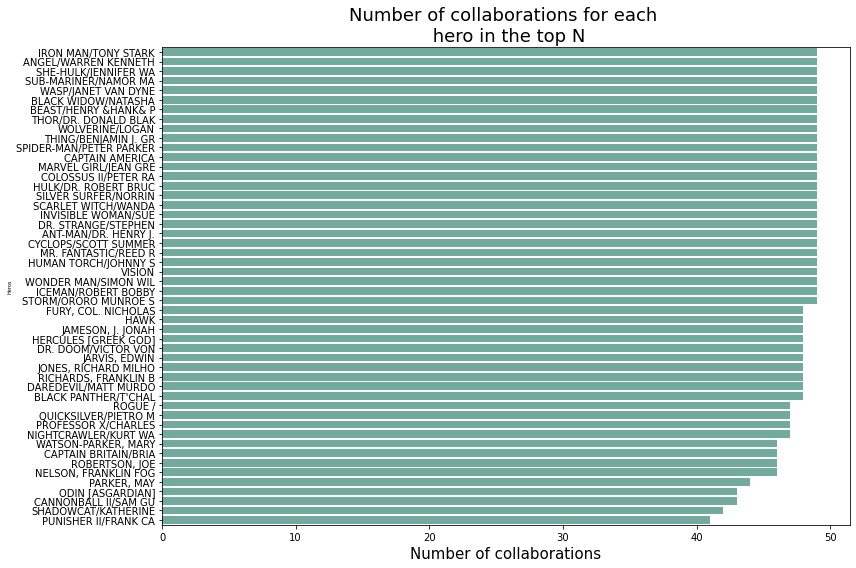

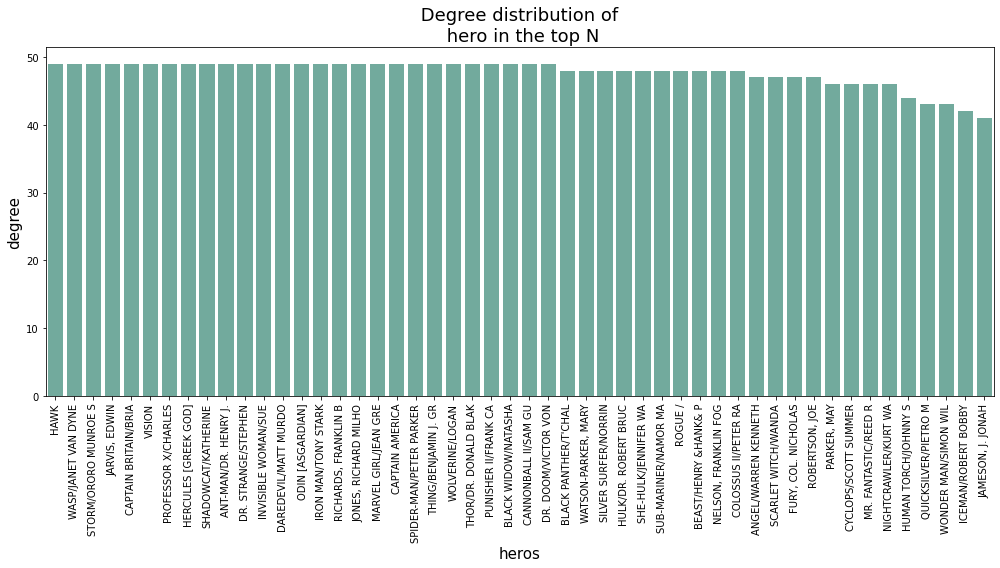

In [130]:
visualization1_type1(G1 , type= 1 , N = 50)

### Query 2
* G : G2
* N : 50

Graph with top N = 50
╒═══════════════════╤═══════════╤══════════════════╤══════════════════════╕
│   Number of nodes │   Density │   Average degree │ Sparse or dense      │
╞═══════════════════╪═══════════╪══════════════════╪══════════════════════╡
│                50 │         0 │                0 │ The graph is sparse. │
╘═══════════════════╧═══════════╧══════════════════╧══════════════════════╛
The hubs of the graph are:
{'BLACK WIDOW/NATASHA': 49, 'VISION': 49, 'ICEMAN/ROBERT BOBBY': 49, 'BEAST/HENRY &HANK& P': 49, 'SUB-MARINER/NAMOR MA': 49, 'ANGEL/WARREN KENNETH': 49, 'ANT-MAN/DR. HENRY J.': 49, 'SILVER SURFER/NORRIN': 49, 'SHE-HULK/JENNIFER WA': 49, 'MR. FANTASTIC/REED R': 49, 'SPIDER-MAN/PETER PARKER': 49, 'HULK/DR. ROBERT BRUC': 49, 'MARVEL GIRL/JEAN GRE': 49, 'INVISIBLE WOMAN/SUE': 49, 'STORM/ORORO MUNROE S': 49, 'WASP/JANET VAN DYNE': 49, 'IRON MAN/TONY STARK': 49, 'CAPTAIN AMERICA': 49, 'THING/BENJAMIN J. GR': 49, 'WONDER MAN/SIMON WIL': 49, 'HUMAN TORCH/JOHNNY S': 49, 'CY

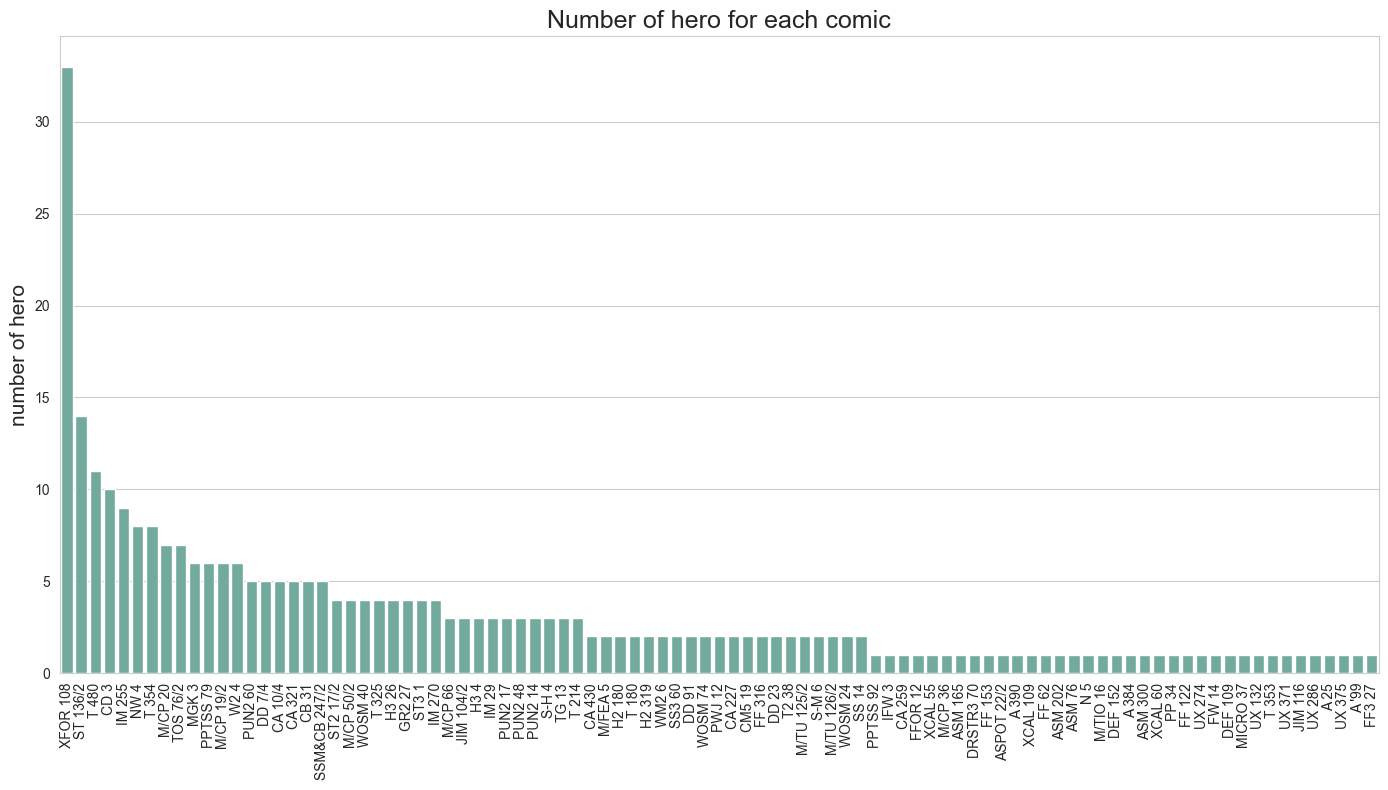

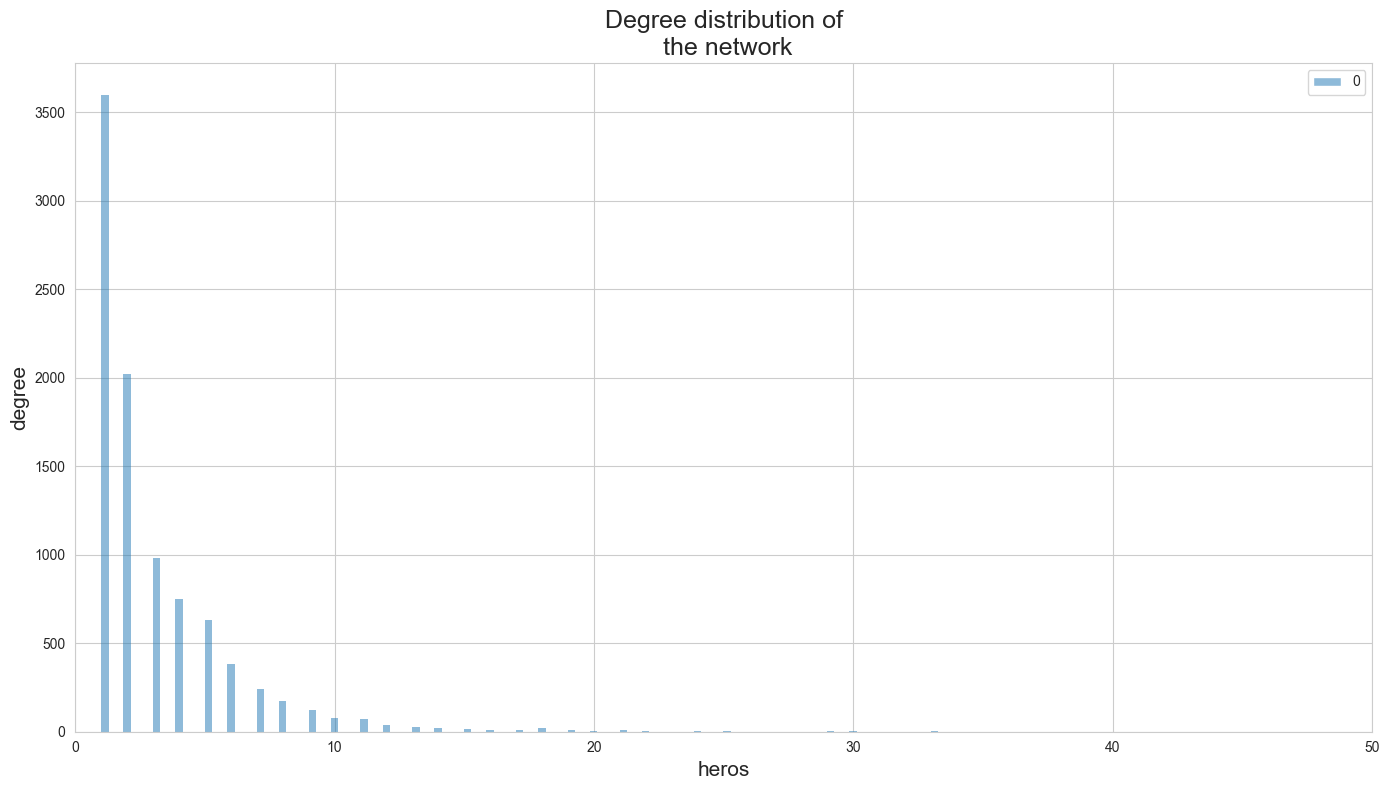

In [36]:
visualization1_type2(G2 , type= 2 , N = 50)

## Visualization 2 - Visualize centrality measure

In [122]:
def viz_functionality_2(g, node: str, metric: str, n: int):
    node_centrality, graph_centrality = functionality_2(g, node, metric, n)
    mean_centrality = np.array(list(graph_centrality.values())).mean() # to compute the average of the centrality measure for all the nodes
    table = [['Metric', 'Node', 'Node score', 'Average Graph Score'], [metric, node, node_centrality, mean_centrality]]
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

Let's first try to visualize the 4 centrality measures when the graph is G1, for the top 5 heroes and for the node 'CAPTAIN AMERICA'

In [270]:
viz_functionality_2(G1, 'CAPTAIN AMERICA', 'degree', 5)
viz_functionality_2(G1, 'CAPTAIN AMERICA', 'pagerank', 5)
viz_functionality_2(G1, 'CAPTAIN AMERICA', 'closeness', 5)
viz_functionality_2(G1, 'CAPTAIN AMERICA', 'betweenness', 5)

╒══════════╤═════════════════╤══════════════╤═══════════════════════╕
│ Metric   │ Node            │   Node score │   Average Graph Score │
╞══════════╪═════════════════╪══════════════╪═══════════════════════╡
│ degree   │ CAPTAIN AMERICA │     0.550477 │            0.00131434 │
╘══════════╧═════════════════╧══════════════╧═══════════════════════╛
╒══════════╤═════════════════╤══════════════╤═══════════════════════╕
│ Metric   │ Node            │   Node score │   Average Graph Score │
╞══════════╪═════════════════╪══════════════╪═══════════════════════╡
│ pagerank │ CAPTAIN AMERICA │     0.105053 │           0.000289184 │
╘══════════╧═════════════════╧══════════════╧═══════════════════════╛
╒═══════════╤═════════════════╤══════════════╤═══════════════════════╕
│ Metric    │ Node            │   Node score │   Average Graph Score │
╞═══════════╪═════════════════╪══════════════╪═══════════════════════╡
│ closeness │ CAPTAIN AMERICA │     0.689882 │               0.43172 │
╘═══════════╧═══

Now let's visualize the centrality measures when the data is referred to graph G2, for the top 5 heroes and for the node 'IRON MAN/TONY STARK'

In [293]:
viz_functionality_2(G2, 'IRON MAN/TONY STARK', 'degree', 5)
viz_functionality_2(G2, 'IRON MAN/TONY STARK', 'pagerank', 5)
viz_functionality_2(G2, 'IRON MAN/TONY STARK', 'closeness', 5)
viz_functionality_2(G2, 'IRON MAN/TONY STARK', 'betweenness', 5)

╒══════════╤═════════════════════╤══════════════╤═══════════════════════╕
│ Metric   │ Node                │   Node score │   Average Graph Score │
╞══════════╪═════════════════════╪══════════════╪═══════════════════════╡
│ degree   │ IRON MAN/TONY STARK │     0.248434 │           0.000558037 │
╘══════════╧═════════════════════╧══════════════╧═══════════════════════╛
╒══════════╤═════════════════════╤══════════════╤═══════════════════════╕
│ Metric   │ Node                │   Node score │   Average Graph Score │
╞══════════╪═════════════════════╪══════════════╪═══════════════════════╡
│ pagerank │ IRON MAN/TONY STARK │    0.0820648 │           0.000215983 │
╘══════════╧═════════════════════╧══════════════╧═══════════════════════╛
╒═══════════╤═════════════════════╤══════════════╤═══════════════════════╕
│ Metric    │ Node                │   Node score │   Average Graph Score │
╞═══════════╪═════════════════════╪══════════════╪═══════════════════════╡
│ closeness │ IRON MAN/TONY STARK │

In both cases we observe that the node's *closeness* score is the highest one and also the one that is closest to the average for all the network nodes, while the *pagerank* is the lowest out of the 4 measures. Moreover, even if the *pagerank* score for a node might not seem that high, it is far above the score for an average node in the graph.

## Visualization 3 - Visualize the shortest-ordered route

In [70]:
def visualize_third_func(edges_list):
    ## If the shortest path from h1 to hn passing though h doesn't exist, then edge_list will be a string
    ## saying 'There is no such path', we print int
    if(isinstance(edges_list, str)):
        print(edges_list)
        return
    # we create a directed graph so we can better represent the path. This graph will contain only the edges that we need for our path.
    G2_di = nx.DiGraph()
    edges_output = [(edges_list[i-1], edges_list[i]) for i in range(1,len(edges_list))] ## we create the edges list
    G2_di.add_edges_from(edges_output) ## we add the edges to the new graph
    ## simple visualization
    visualize_simple(G2_di)
    ## spring layout visualization
    visualize_spring(G2_di, edges_output)
    ## return the list with the path
    return edges_output

In [71]:
def visualize_simple(G2_output):
    plt.clf()
    nx.draw(G2_output, with_labels = True, node_color="lightGreen", font_size=6)
    plt.show()

In [72]:
def visualize_spring(G2_output,edges_output):
    seed = 34324  # Seed random number generators for reproducibility
    pos = nx.spring_layout(G2_output, seed=seed)

    node_sizes = [50 for i in range(len(G2_output))]
    M = G2_output.number_of_edges()
    edge_colors = range(2, M + 2)
    cmap = plt.cm.plasma

    nodes = nx.draw_networkx_nodes(G2_output, pos, node_size=node_sizes, node_color="skyBlue")
    edges = nx.draw_networkx_edges(
        G2_output,
        pos,
        node_size=10,
        arrowstyle="->",
        arrowsize=20,
        edge_color=edge_colors,
        edge_cmap=cmap,
        width=1.3,
    )

    pc = mpl.collections.PatchCollection(edges, edges_output, cmap=cmap)
    pc.set_array(edge_colors)

    ax = plt.gca()
    ax.set_axis_off()
    plt.legend(['Nodes']+edges_output,  prop={'size': 5})
    plt.figure(figsize=(200, 200), dpi=360)
    plt.show()


In [79]:
h = [
'SPIDER-MAN/PETER PARKER',
'OSBORN, HARRY']
h1 = 'IRON MAN/TONY STARK'
hn = 'MOON KNIGHT/MARC SPE'
N = 100

In [80]:
OUTPUT = functionality_3(G2, h, h1, hn, N)

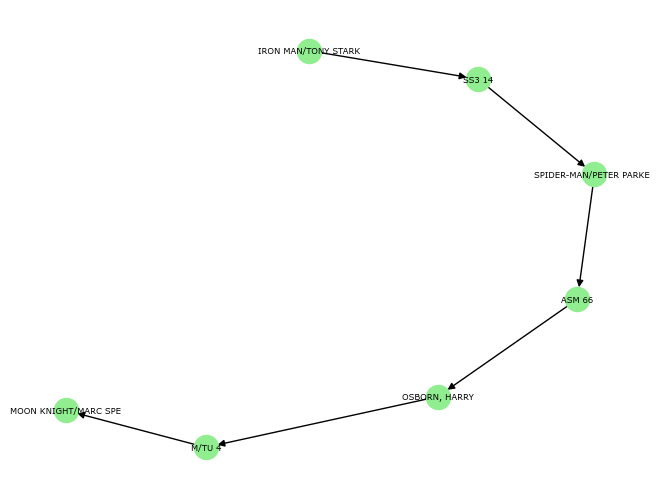

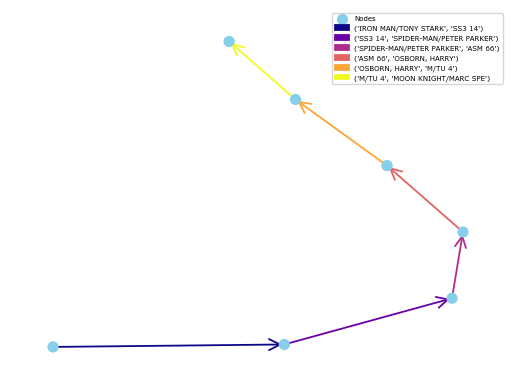

<Figure size 72000x72000 with 0 Axes>

In [82]:
path = visualize_third_func(OUTPUT)

### Shortest Path

In [76]:
if(path):
    for i in range(0,len(path)):
        print('Step {}: {}, {}'.format(i, path[i][0], path[i][1]))

Step 0: IRON MAN/TONY STARK, SS3 14
Step 1: SS3 14, SPIDER-MAN/PETER PARKER
Step 2: SPIDER-MAN/PETER PARKER, ASM 66
Step 3: ASM 66, OSBORN, HARRY
Step 4: OSBORN, HARRY, M/TU 4
Step 5: M/TU 4, MOON KNIGHT/MARC SPE


## Visualization 4 - Visualize the disconnected graph

In [194]:
def visualization4_type1(G, heroA, heroB, num_edges_removed, edges_removed, min_cut):

    print("Number of links removed: {}".format(num_edges_removed))
    print("Minimum cut value: {}\n".format(round(min_cut, 4)))

    pos = nx.spring_layout(G)

    # Original graph plot
    print("Original graph:")
    plt.figure(figsize=(20,12))
    weights = [G[u][v]['weight']*5 for u,v in G.edges()]
    nx.draw_networkx(G, pos, font_size=10, node_color='#ff9900', font_family='sans-serif', edgecolors="#73e600", edge_color="#73e600", width=weights, font_color='black')
    plt.show()

    # New graph plot
    G_new = G.copy()
    G_new.remove_edges_from(edges_removed)

    print("New graph:")
    plt.figure(figsize=(20,12))
    weights = [G[u][v]['weight']*5 for u,v in G_new.edges()]
    nx.draw_networkx(G_new, pos, font_size=10, node_color='#ff9900', font_family='sans-serif', edgecolors="#73e600", edge_color="#73e600", width=weights, font_color='black')
    nx.draw_networkx(G_new.subgraph(heroA), pos=pos, font_size=10, node_color='#ff3300', font_family='sans-serif', edgecolors="#73e600", font_color='black', node_size=1000)
    nx.draw_networkx(G_new.subgraph(heroB), pos=pos, font_size=10, node_color='#66ffff', font_family='sans-serif', edgecolors="#73e600", font_color='black', node_size=1000)
    plt.show()

    return

In [19]:
def visualization4_type2(G, heroA, heroB, num_edges_removed, edges_removed, min_cut, N = -1):

    print("Number of links removed: {}".format(num_edges_removed))
    print("Minimum cut value: {}\n".format(round(min_cut, 4)))

    pos = nx.spring_layout(G)

    # Original graph plot
    print("Original graph:")
    plt.figure(figsize=(20,12))
    nx.draw_networkx_nodes(G, pos, node_color='#ffff99', edgecolors="#73e600", node_size=100, label='Comic')
    nx.draw_networkx_edges(G, pos, edge_color="#73e600")
    nx.draw_networkx(G.subgraph(top_n(N)), pos=pos, font_size=10, node_color='#ff9900', font_family='sans-serif', edgecolors="#73e600", font_color='black', node_size=100, label='Hero')
    plt.legend(scatterpoints = 1)
    plt.show()

    # New graph plot
    G_new = G.copy()
    G_new.remove_edges_from(edges_removed)

    print("New graph:")
    plt.figure(figsize=(20,12))
    nx.draw_networkx_nodes(G_new, pos, node_color='#ffff99', edgecolors="#73e600", node_size=100, label='Comic')
    nx.draw_networkx_edges(G_new, pos, edge_color="#73e600")
    nx.draw_networkx(G_new.subgraph(top_n(N)), pos=pos, font_size=10, node_color='#ff9900', font_family='sans-serif', edgecolors="#73e600", font_color='black', node_size=100, label='Hero')
    nx.draw_networkx(G_new.subgraph(heroA), pos=pos, font_size=10, node_color='#ff3300', font_family='sans-serif', edgecolors="#73e600", font_color='black', node_size=1000)
    nx.draw_networkx(G_new.subgraph(heroB), pos=pos, font_size=10, node_color='#66ffff', font_family='sans-serif', edgecolors="#73e600", font_color='black', node_size=1000)
    plt.legend(scatterpoints = 1)
    plt.show()

    return

### Query 1:

* **Graph**: $G1$
* **HeroA**: *SPIDER-MAN/PETER PARKER*
* **HeroB**: *CAPTAIN AMERICA*
* **N**: 25

In [35]:
# Input data and parameters
G_input = G1
heroA = 'SPIDER-MAN/PETER PARKER'
heroB = 'CAPTAIN AMERICA'
N = 25

G_type = 1 if G_input==G1 else 2

In [36]:
num_edges_removed, edges_removed, min_cut, G = functionality_4(G_input, G_type, heroA, heroB, N)

Number of links removed: 24
Minimum cut value: 0.2565

Original graph:


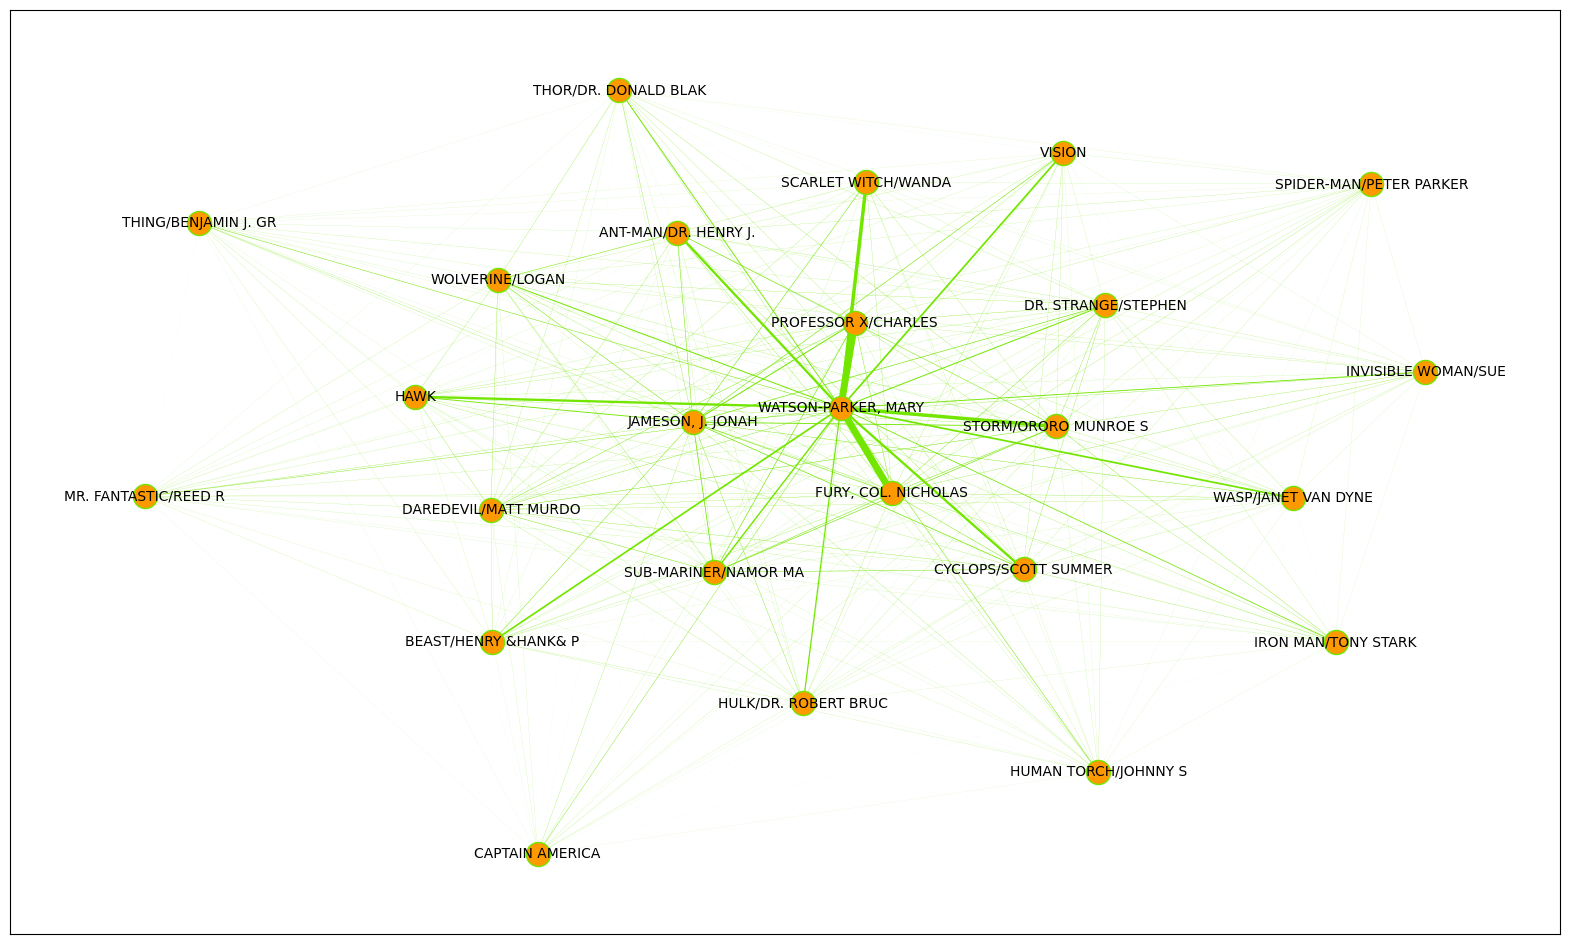

New graph:


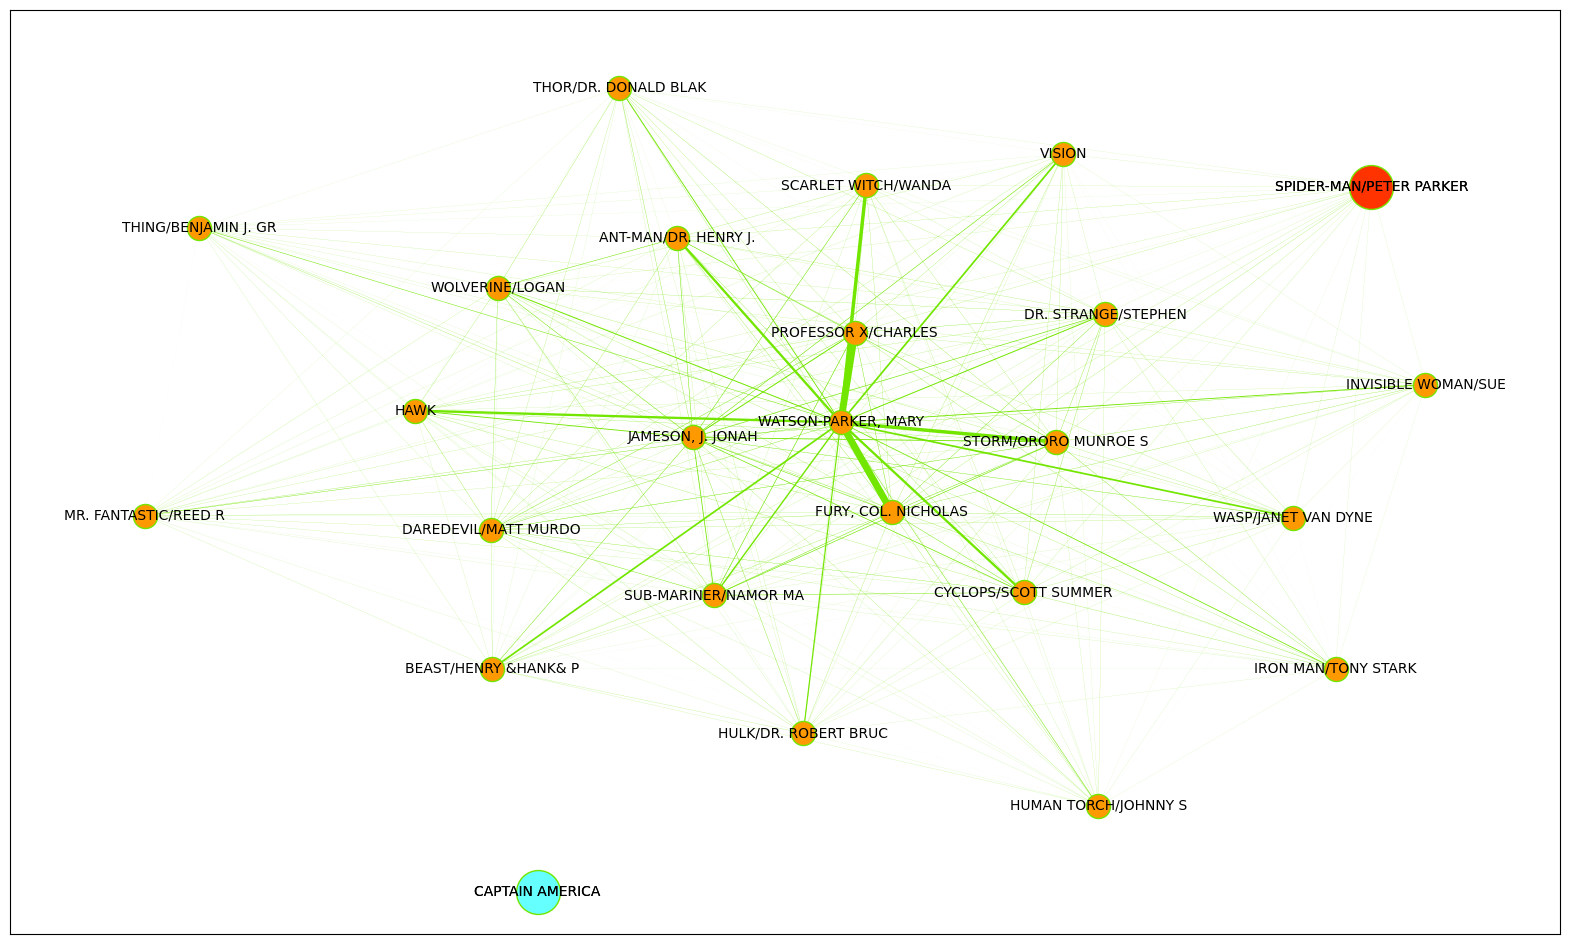

In [199]:
visualization4_type1(G, heroA, heroB, num_edges_removed, edges_removed, min_cut)

The first plot depicts the *original* graph of the *top 25* heroes (a fairly small value of N is selected *for visualization purposes*). Edges width represents links **weight**.

The second plot depicts the *new* graph, after edges removal. The **heroA** (*red*) and **heroA** (*light blue*) nodes are *highlighted*.

For this query, the **minimum cut** disconnects the graph in two subgraphs $G_a$ and $G_b$, with the former (related to **heroA**) including *all the nodes* but the **heroB**.

### Query 2: G2

* **Graph**: $G2$
* **HeroA**: *SPIDER-MAN/PETER PARKER*
* **HeroB**: *CAPTAIN AMERICA*
* **N**: 5

In [32]:
# Input data and parameters
G_input = G2
heroA = 'SPIDER-MAN/PETER PARKER'
heroB = 'CAPTAIN AMERICA'
N = 5

G_type = 1 if G_input==G1 else 2

In [ ]:
num_edges_removed, edges_removed, min_cut, G = functionality_4(G_input, G_type, heroA, heroB, N)

Number of links removed: 234
Minimum cut value: 234

Original graph:


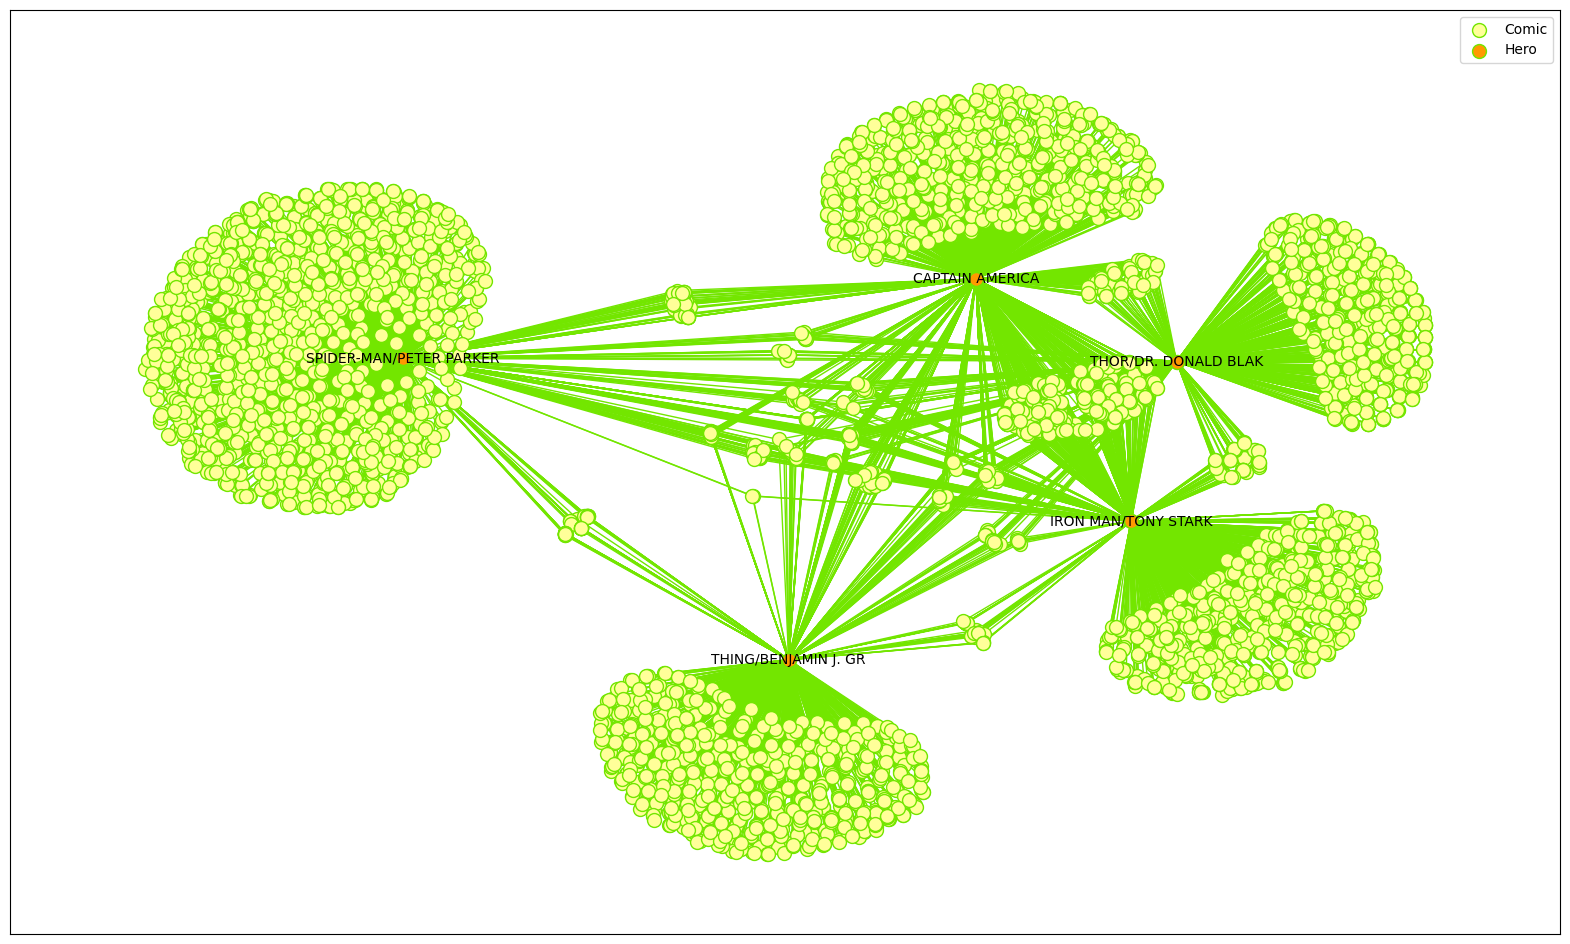

New graph:


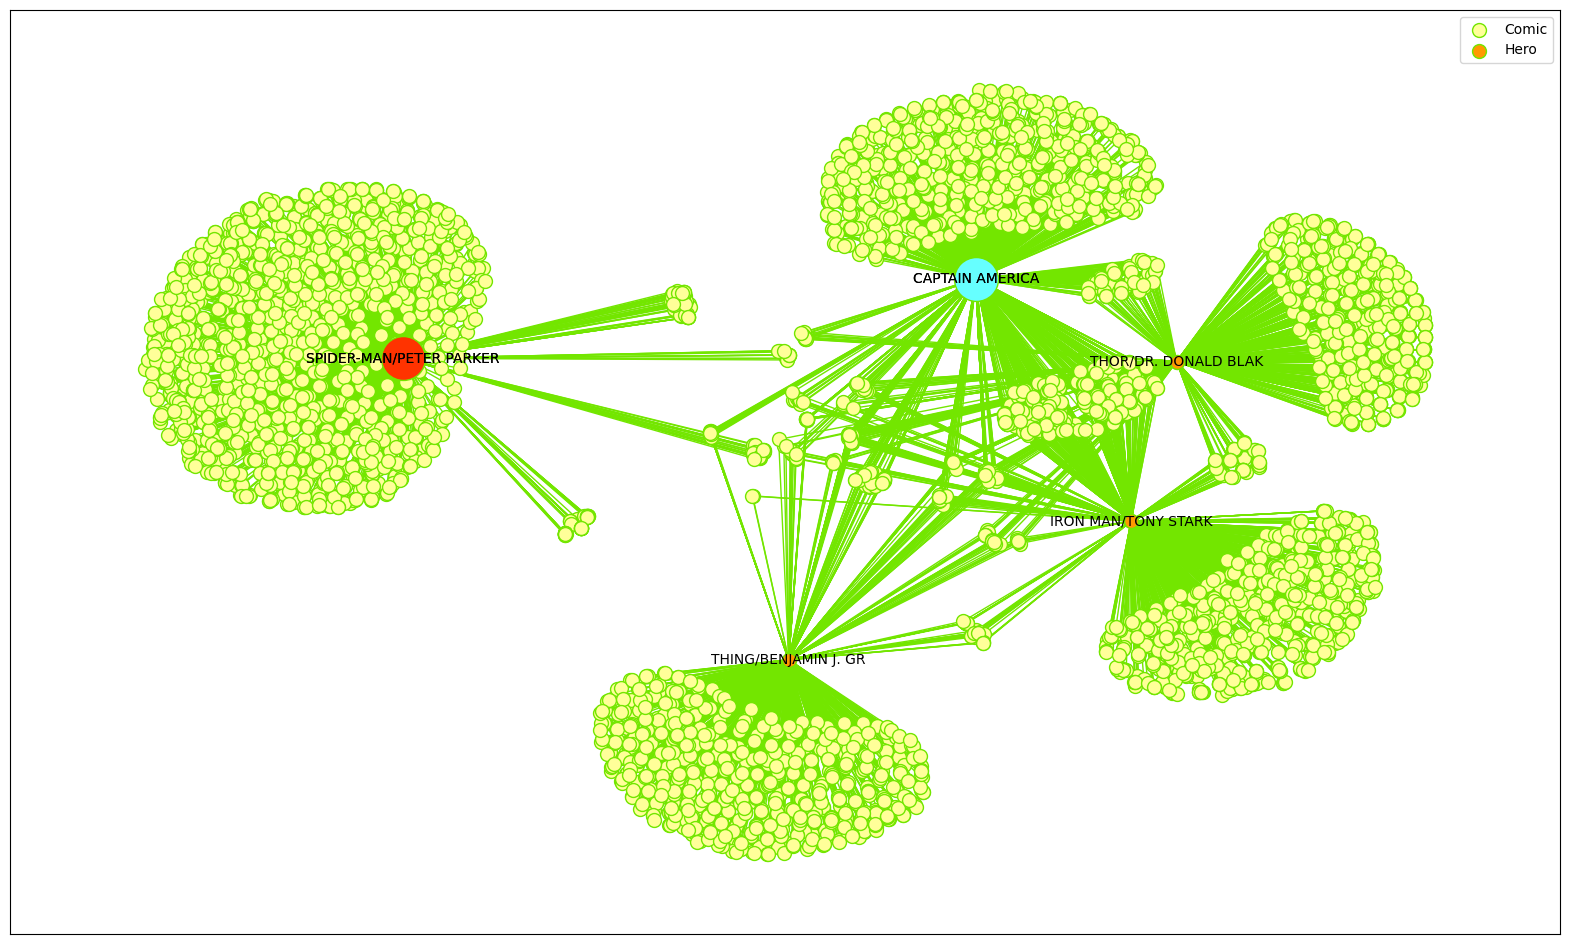

In [216]:
visualization4_type2(G, heroA, heroB, num_edges_removed, edges_removed, min_cut, N)

The *original* graph (depicted in the first plot) is this time filtered for the *top 5* heroes: due to the **structure** of the $G2$ graph, including both *hero* (*orange*) and *comic* (*yellow*) nodes, it is convenient to select a value of N **much smaller** than before in order to allow for *meaningful visualization* (for each *hero*, all the *comics* in which the *hero* has appeared into are also retrieved).

As for the previous query, one of the resulting subgraph (the one related to **heroA** in this case) includes **no other hero node** but only *comic nodes*, while the second one is composed of **all the other N-1 heroes** together with the remaining *comics*.

## Visualization 5 - Visualize the communities

In [32]:
def visualization5(G , heroA , heroB , N):
    print("Hero 1: {}".format(heroA))
    print("Hero 2: {}\n".format(heroB))
    G = G.subgraph(top_n(N))
    community, count , same = functionality_5(G , hero1 = heroA ,hero2 = heroB , N = N )
    print(f"The number of links that should be removed to have the communities are: {count}")

    pos = nx.spring_layout(G)
    # Original graph
    print('Original graph:')
    plt.figure(figsize = (20,12))
    weights = [G[u][v]['weight']*5 for u,v in G.edges()]
    nx.draw_networkx(G, pos, font_size=10, node_color='#ff9900', font_family='sans-serif', edgecolors="#73e600", edge_color="#73e600", width=weights, font_color='black')
    plt.show()

    # New plot graph
    print('New graph')
    col = []
    for x in community:
        for j in x:
            if j == "None":
                continue
            if j in community[0]:
                col.append("#ff9900")
            else:
                col.append("Red")
    plt.figure(figsize = (20,12))
    nx.draw_networkx(G, pos, font_size=10, node_color= col, font_family='sans-serif', edgecolors="#73e600", edge_color="#73e600", width=weights, font_color='black')
    plt.show()

    # Final plot (only heroA and heroB)
    print(f"Plot with label only {heroA} and {heroB}")
    heros = [heroA , heroB]
    labels = {node:node for node in heros}
    plt.figure(figsize = (20,12))
    nx.draw_networkx(G, pos, with_labels=False , font_size=10, node_color= col, font_family='sans-serif', edgecolors="#73e600", edge_color="#73e600", width=weights, font_color='black')
    nx.draw_networkx_labels(G, pos= pos , labels=labels ,font_color= "RED")
    plt.show()

    # Table of communities
    list1 = community[0]
    list2 = community[1]

    # Pad the shorter list with None values
    if len(list1) < len(list2):
        list1 += ["None"] * (len(list2) - len(list1))
    elif len(list2) < len(list1):
        list2 += ["None"] * (len(list1) - len(list2))
    print("Community 1,                  Community 2")
    # Print the table
    for item1, item2 in zip(list1, list2):
        print(f'{item1:<25} ||| {item2:<25}')
    return




### Query 1
* G : G1
* heroA : CAPTAIN AMERICA
* heroB : IRON MAN/TONY STARK
* N : 40

Hero 1: CAPTAIN AMERICA
Hero 2: IRON MAN/TONY STARK

The number of links that should be removed to have the communities are: 35
Original graph:


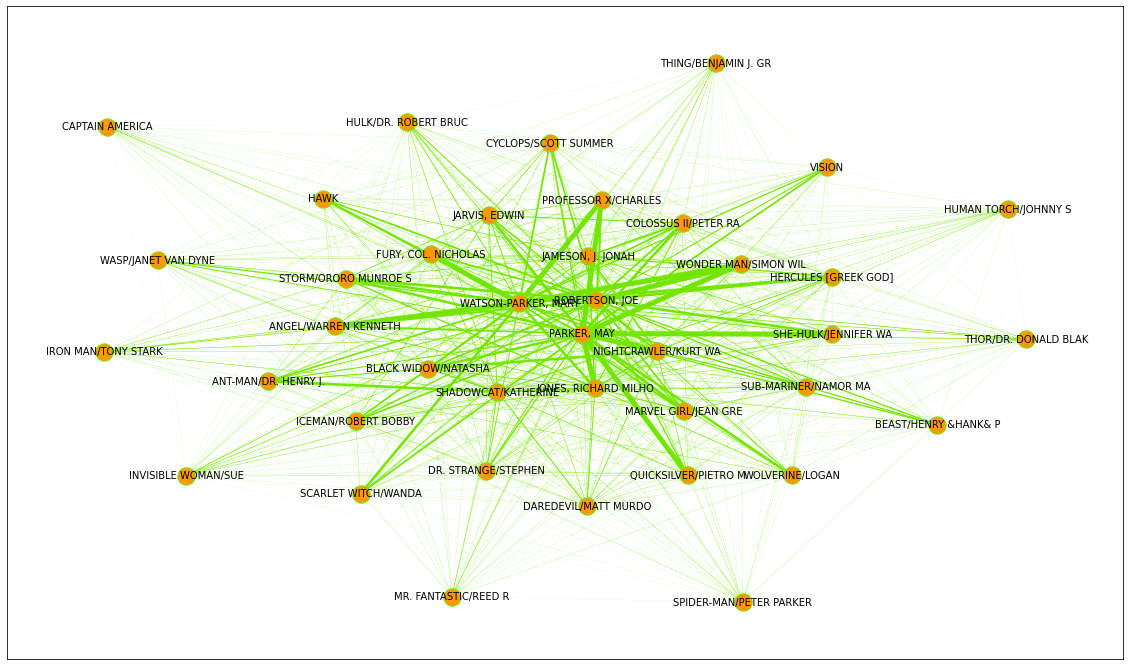

New graph


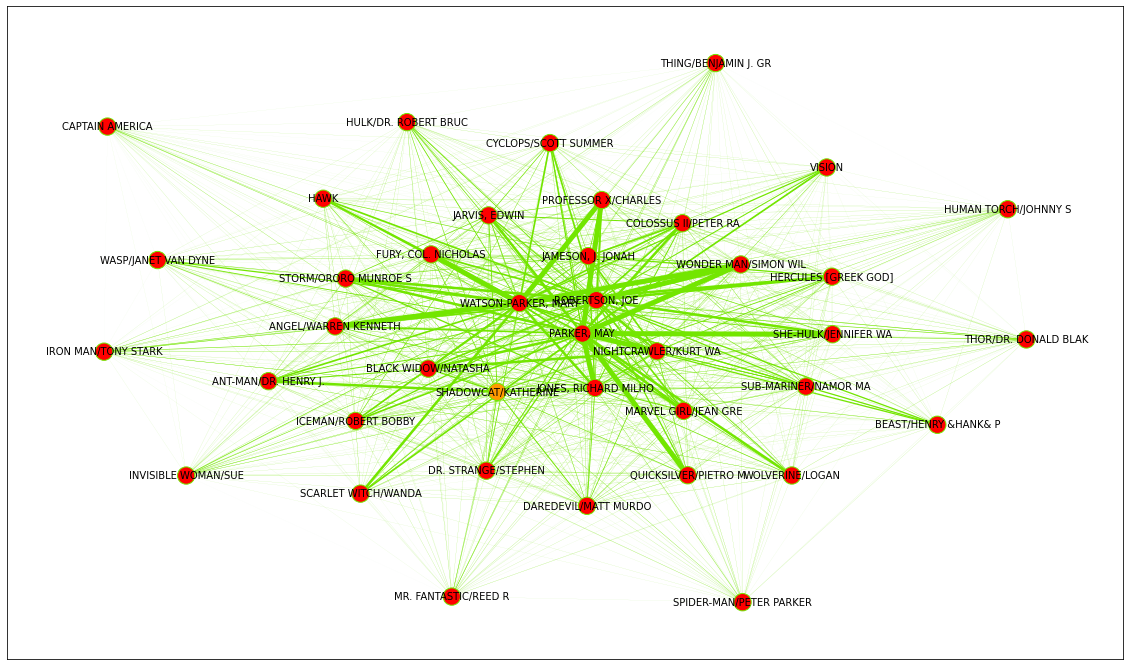

Plot with label only CAPTAIN AMERICA and IRON MAN/TONY STARK


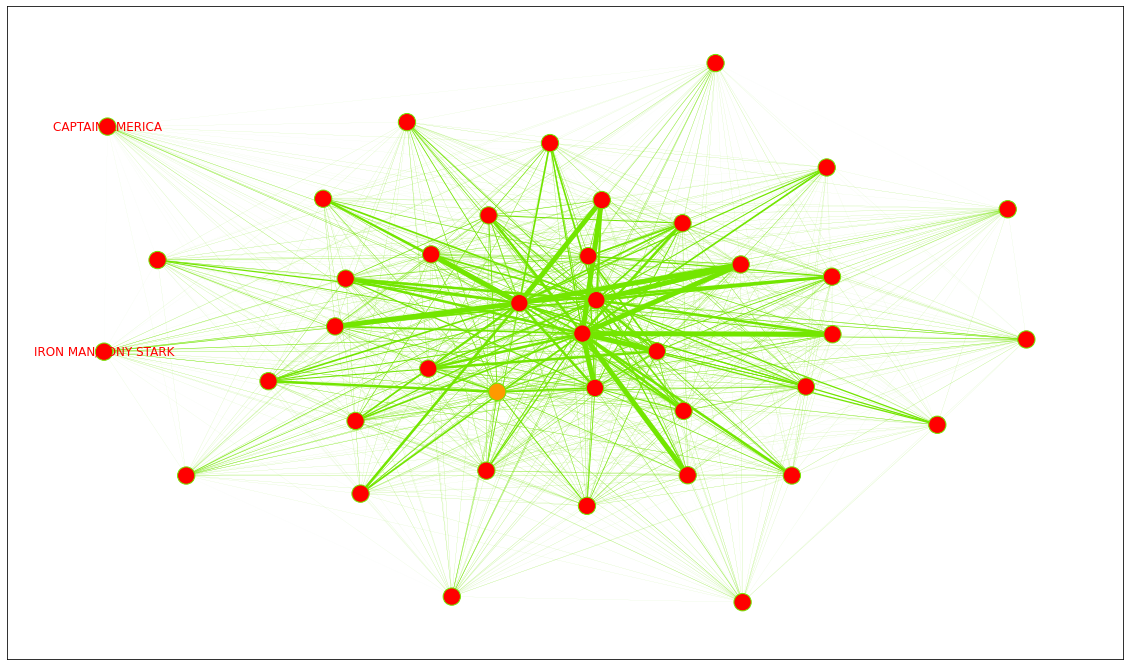

Community 1,                  Community 2
SHADOWCAT/KATHERINE       ||| FURY, COL. NICHOLAS      
None                      ||| ANGEL/WARREN KENNETH     
None                      ||| NIGHTCRAWLER/KURT WA     
None                      ||| ICEMAN/ROBERT BOBBY      
None                      ||| MR. FANTASTIC/REED R     
None                      ||| STORM/ORORO MUNROE S     
None                      ||| DAREDEVIL/MATT MURDO     
None                      ||| HUMAN TORCH/JOHNNY S     
None                      ||| THOR/DR. DONALD BLAK     
None                      ||| COLOSSUS II/PETER RA     
None                      ||| ANT-MAN/DR. HENRY J.     
None                      ||| JAMESON, J. JONAH        
None                      ||| WOLVERINE/LOGAN          
None                      ||| SUB-MARINER/NAMOR MA     
None                      ||| BEAST/HENRY &HANK& P     
None                      ||| JARVIS, EDWIN            
None                      ||| MARVEL GIRL/JEAN GRE     
None  

In [34]:
visualization5(G1 , heroA = "CAPTAIN AMERICA" ,heroB= "IRON MAN/TONY STARK" , N = 40 )

The *Girvan–Newman* algorithm is an algorithm for finding communities within a graph. It works by iteratively removing the "most central" (considering "betweenness centrality") edges from the graph, and then identifying the connected components of the remaining graph as the communities.
If more than one edge has the same highest betweenness centrality in a given iteration of the *Girvan-Newman* algorithm, the algorithm can choose any of those edges to remove.

However, the betweenness centrality of an edge is a measure of how much it lies on the shortest path between two other nodes and not a measure of centrality of an edge. This means that an edge with a high betweenness centrality may not necessarily be the most important edge within a community.

# Algorithmic Question

The idea we used for solving the question is the following:
* 1) Generate all possible moves in a 3x3 matrix that can be generated by the input sequence:


    example:    input sequence = "DRU"

    all the possible moves in a 3x3 matrix are :

    ['DRU', 'DRUU', 'DRRU', 'DRRUU', 'DDRU', 'DDRUU', 'DDRRU', 'DDRRUU'].
* 2) for all of these possible moves we compute the path for all the starting position of the matrix:
\begin{matrix}
(0,0) & (0,1) & (0,2)\\
(1,0) & (1,1) & (1,2)\\
(2,0) & (2,1) & (2,2)
\end{matrix}

    little hack : all the moves have some impossible start positions:

    i.e. : The move "right" can't start from the right side of the matrix


* 3) check 2 condition:

    *  3.1) Condition 1 : the path has to be always inside the matrix
    *  3.2) Condition 2 : the path has not to intersect with itself even at one point
    If both the conditions are true we increase the count by 1.
* 4) Return the count

In [149]:
def add_path(l : list , letter : str):
    if len(l) == 0:     # list is empty
        return([letter, letter*2])    # Add the first two element
    path = []           # Pre-set the path
    for sub_path in l:  # Loop over all the sub_path
        for i in range(1,3):  # We can at most twice
            path.append( sub_path+ i*letter)   # Append the sub_path
    return path

In [150]:
def condition_1( position : tuple , l : list):
    for x in l :     # Loop over the move list
        if x == "R": # Move right
            position = (position[0] , position[1] + 1)
        if x == "L": # Move left
            position = (position[0] , position[1] - 1)
        if x == "D": # Move down
            position = (position[0] + 1, position[1])
        if x == "U": # Move up
            position = (position[0] - 1, position[1])
        # Condition to be inside the matrix
        if position[0] < 0 or position[0] > 2:
            return False
        if position[1] < 0 or position[1] > 2:
            return False
    #  from the position provides the path is inside the matrix
    return True


In [157]:
def condition_2( position : tuple , l : list):
    pattern = [position]   # Record the pattern
    for x in l :           # Loop over the moves
        if x == "R":       # Move right
            position = (position[0] , position[1] + 1)
        if x == "L":        # Move left
            position = (position[0] , position[1] - 1)
        if x == "D":        # Move down
            position = (position[0] + 1, position[1])
        if x == "U":        # Move up
            position = (position[0] - 1, position[1])
        # The path does intersect with itself
        if position in pattern:
            return False
        # record the current position
        else:
            pattern.append(position)
    # The path does not intersect with itself
    return True


In [162]:
def number_of_patterns(sequence : str):
    all_possible_path = []   # Pre-set all the possible path
    for segment in sequence: # Loop over the letters of the input sequence
        all_possible_path = add_path(all_possible_path , segment)
    # All possible position  that we can start for a given start move
    start_pos = {   "R": [(0 , 0) , (0 , 1) , (1 , 0) , (1 , 1) , (2 , 0) , (2 , 1)] ,
                    "L": [(0 , 1) , (0 , 2) , (1 , 1) , (1 , 2) , (2 , 1) , (2 , 2)] ,
                    "U": [(1 , 0) , (1 , 1) , (1 , 2) , (2 , 0) , (2 , 1) , (2 , 2)] ,
                    "D": [(0 , 0) , (0 , 1) , (0 , 2) , (1 , 0) , (1 , 1) , (1 , 2)]}
    count = 0                # Set the count to 0
    for start in start_pos[sequence[0]]:   # Loop over the possible start positions
        for path in all_possible_path:     # Loop over all the possible path
            if condition_1(start , path ) and condition_2(start , path):  # check if the are respected
                count += 1   # Increase the count by 1
    return count




In [163]:
number_of_patterns("R")

9

In [164]:
number_of_patterns("DRU")

15

In [160]:
number_of_patterns("LDRDRUL")

0